In [1]:
# Load pickled data
import pickle
from sklearn.utils import shuffle

# TODO: Fill this in based on where you saved the training and testing data
training_file = "data/train.p"
validation_file= "data/valid.p"
testing_file = "data/test.p"
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
# colour eequalise
import cv2
import numpy as np

def col_equalise(img):
    lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    # split by channel
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    return final

# histogram equalization
# http://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html

X_train = np.array([col_equalise(img) for img in X_train])
X_valid = np.array([col_equalise(img) for img in X_valid])
X_test = np.array([col_equalise(img) for img in X_test])

### Pre-process the Data Set (normalization, grayscale, etc.)

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

### Model Architecture

In [11]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
import tensorflow as tf
from tensorflow.contrib.layers import flatten

EPOCHS = 25
BATCH_SIZE = 128

In [12]:
def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    #  Activation.
    conv1 = tf.nn.relu(conv1)


    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    #  Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)
    #conv2 = tf.nn.dropout(conv2, 0.75)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    #fc1 = tf.nn.dropout(fc1, 0.75)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
    #fc2 = tf.nn.dropout(fc2, 0.75)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [13]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

In [14]:
logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)

rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)
training_operation = tf.train.AdamOptimizer(learning_rate = rate).minimize(loss_operation)


In [15]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [16]:
%%time
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        training_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet_traffic_benchmark_gpu')
    print("Model saved")

Training...

EPOCH 1 ...
Training Accuracy = 0.688
Validation Accuracy = 0.649

EPOCH 2 ...
Training Accuracy = 0.834
Validation Accuracy = 0.764

EPOCH 3 ...
Training Accuracy = 0.890
Validation Accuracy = 0.814

EPOCH 4 ...
Training Accuracy = 0.917
Validation Accuracy = 0.833

EPOCH 5 ...
Training Accuracy = 0.941
Validation Accuracy = 0.859

EPOCH 6 ...
Training Accuracy = 0.954
Validation Accuracy = 0.859

EPOCH 7 ...
Training Accuracy = 0.965
Validation Accuracy = 0.884

EPOCH 8 ...
Training Accuracy = 0.972
Validation Accuracy = 0.873

EPOCH 9 ...
Training Accuracy = 0.969
Validation Accuracy = 0.879

EPOCH 10 ...
Training Accuracy = 0.979
Validation Accuracy = 0.886

EPOCH 11 ...
Training Accuracy = 0.977
Validation Accuracy = 0.883

EPOCH 12 ...
Training Accuracy = 0.978
Validation Accuracy = 0.892

EPOCH 13 ...
Training Accuracy = 0.983
Validation Accuracy = 0.897

EPOCH 14 ...
Training Accuracy = 0.983
Validation Accuracy = 0.892

EPOCH 15 ...
Training Accuracy = 0.982
Valid

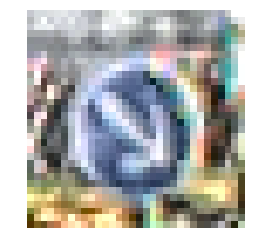

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
image_disp = X_train[1100]
plt.axis('off')
plt.imshow(image_disp)

In [21]:
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

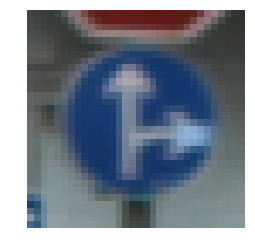

In [24]:
image_disp = train['features'][1100]
plt.axis('off')
plt.imshow(image_disp)

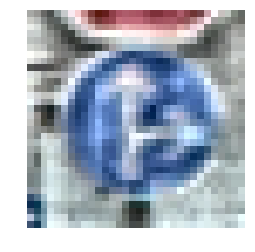

In [25]:
plt.axis('off')
plt.imshow(col_equalise(image_disp))


In [17]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from .\lenet_traffic_benchmark_gpu
Test Accuracy = 0.886
